In [1]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('易速鲜花订单记录.csv') #载入数据
df_sales.head() #显示头几行数据 

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


In [2]:
city = pd.get_dummies(df_sales.城市, prefix='城市')
df_sales = pd.concat([df_sales, city], axis=1)
df_sales

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,城市_上海,城市_北京,城市_广州,城市_成都,城市_深圳,城市_苏州,城市_西安
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京,0,1,0,0,0,0,0
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海,1,0,0,0,0,0,0
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,1,0,0,0,0,0,0
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京,0,1,0,0,0,0,0
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87175,581585,21684,6/9/2021 12:31,产品说明掩码,12,5.00,15804,深圳,0,0,0,0,1,0,0
87176,581585,22398,6/9/2021 12:31,产品说明掩码,12,499.00,15804,深圳,0,0,0,0,1,0,0
87177,581585,23328,6/9/2021 12:31,产品说明掩码,4,58.00,15804,深圳,0,0,0,0,1,0,0
87178,581585,23145,6/9/2021 12:31,产品说明掩码,12,88.90,15804,深圳,0,0,0,0,1,0,0


In [3]:
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转换日期格式
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01'] #只保留整月数据
print('日期范围（删除不完整的月份）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围

日期范围（删除不完整的月份）: 2020-06-01 09:09:00 ~ 2021-05-31 17:39:00


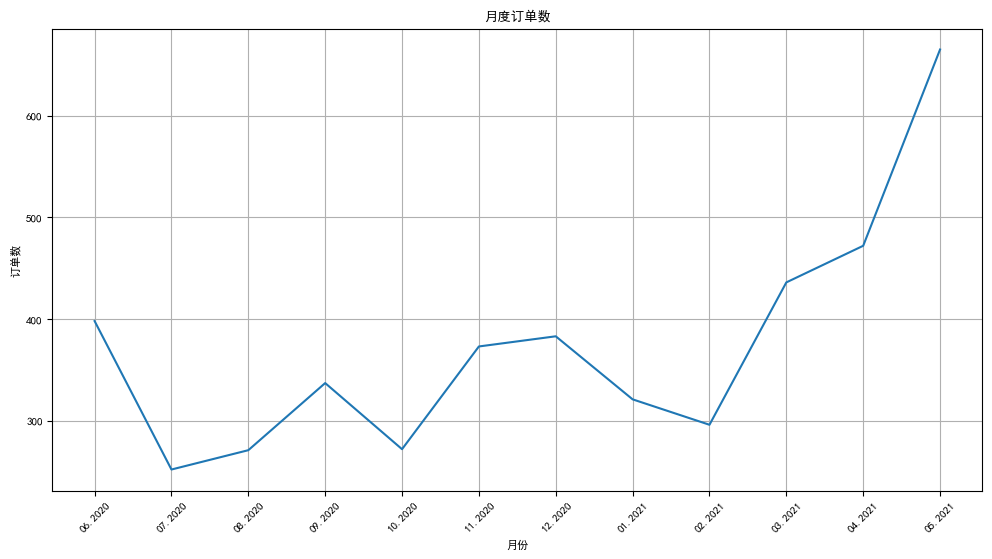

In [13]:
import matplotlib.pyplot as plt #导入Matplotlib的pyplot模块

plt.rc('font', family='SimHei', size=8) #定义全局图中字体
#构建月度的订单数的DataFrame
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()
#设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份') # X轴label
ax.set_ylabel('订单数') # Y轴Label
ax.set_title('月度订单数') # 图题
#设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show() # 绘图

In [7]:
#data clean
df_sales = df_sales.drop_duplicates() #删除重复的数据行
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价

df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')] #构建仅含头三个月数据的数据集
df_sales_3m.reset_index(drop=True) #重置索引

#构建User用户表
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user.columns = ['用户码'] #设定字段名
df_user.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user = pd.merge(df_user, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user = pd.merge(df_user, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user #显示用户表结构


,用户码,R值,F值,M值
0,15100,45,6,635.10
1,15291,35,35,1329.95
2,14688,6,85,1472.28
3,15311,5,715,12711.66
4,15862,89,64,354.23
...,...,...,...,...
365,15951,1,22,375.17
366,14745,1,7,240.60
367,15724,0,5,103.65
368,15874,0,5,584.35


In [8]:
#构建标签
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index() #计算每个用户整年消费总额，构建df_user_1y对象
df_user_1y.columns = ['用户码','年度LTV'] #设定字段名
df_user_1y.head() #显示头几行数据
df_LTV = pd.merge(df_user, df_user_1y, on='用户码', how='left') #构建整体LTV训练数据集
df_LTV #显示df_LTV

,用户码,R值,F值,M值,年度LTV
0,15100,45,6,635.10,635.10
1,15291,35,35,1329.95,4596.51
2,14688,6,85,1472.28,4449.48
3,15311,5,715,12711.66,58218.04
4,15862,89,64,354.23,659.73
...,...,...,...,...,...
365,15951,1,22,375.17,375.17
366,14745,1,7,240.60,1167.16
367,15724,0,5,103.65,212.30
368,15874,0,5,584.35,4330.67


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression #导入线性回归模型
from sklearn.tree import DecisionTreeRegressor #导入决策树回归模型
from sklearn.ensemble import RandomForestRegressor #导入随机森林回归模型

X = df_LTV.drop(['用户码','年度LTV'],axis=1) #特征集
y = df_LTV['年度LTV'] #标签集

# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 36)
# 再把其它集拆分成验证集和测试集 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 36)


model_lr = LinearRegression() #创建线性回归模型
model_dtr = DecisionTreeRegressor() #创建决策树回归模型
model_rfr = RandomForestRegressor() #创建随机森林回归模型

#train
model_lr.fit(X_train, y_train) #拟合线性回归模型
model_dtr.fit(X_train, y_train) #拟合决策树模型
model_rfr.fit(X_train, y_train) #拟合随机森林模型

#validate
y_valid_preds_lr = model_lr.predict(X_valid) #用线性回归模型预测验证集
y_valid_preds_dtr = model_dtr.predict(X_valid) #用决策树模型预测验证集
y_valid_preds_rfr = model_rfr.predict(X_valid) #用随机森林模型预测验证集

#example
print('真值:', y_valid.iloc[2])  #线性回归模型预测值
print('线性回归预测值:', y_valid_preds_lr[2])  #线性回归模型预测值
print('决策树预测值:', y_valid_preds_dtr[2])  #决策树模型预测值
print('随机森林预测值:', y_valid_preds_rfr[2]) #随机森林模型预测值

真值: 4391.94
线性回归预测值: 7549.228946781511
决策树预测值: 7904.28
随机森林预测值: 4558.004300000004


In [10]:
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('验证集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('验证集上的R平方分数-决策树: %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('验证集上的R平方分数-随机森林: %0.4f' % r2_score(y_valid, model_rfr.predict(X_valid)))

验证集上的R平方分数-线性回归: 0.4333
验证集上的R平方分数-决策树: 0.3138
验证集上的R平方分数-随机森林: 0.5230


Text(0.5, 1.0, '实际值 vs. 预测值')

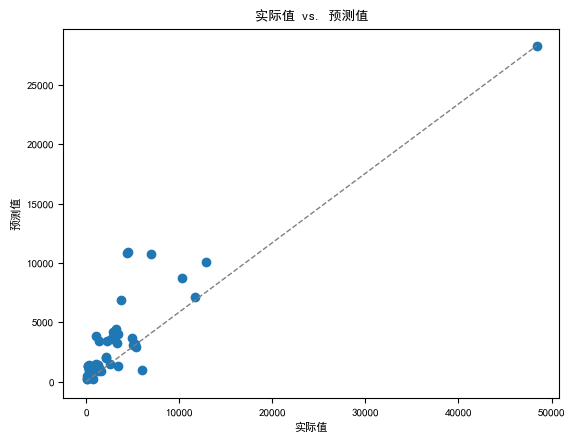

In [14]:
#利用表现最好的随机森林模型来制图
y_test_preds_rfr = model_rfr.predict(X_test) #用模型预随机森林模型预测验证集
plt.scatter(y_test, y_test_preds_rfr) #预测值和实际值的散点图
plt.plot([0, max(y_test)], [0, max(y_test_preds_rfr)],   color='gray', lw=1, linestyle='--') #绘图
plt.xlabel('实际值') #X轴
plt.ylabel('预测值') #Y轴
plt.title('实际值 vs. 预测值') #标题

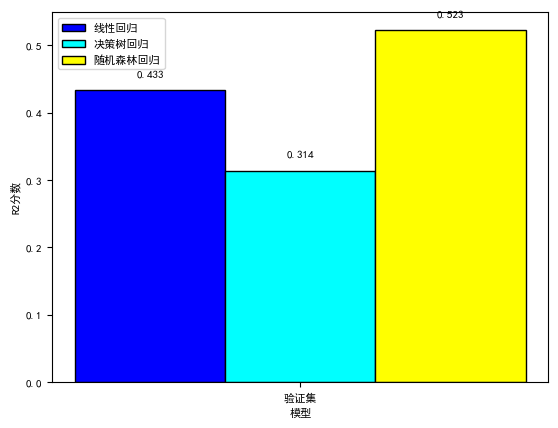

In [15]:
import numpy as np #导入NumPy
  
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i/50+x[i], round(y[i], 3)+0.02, round(y[i], 3), ha = 'center')

# fig = plt.figure()
fig, ax = plt.subplots()    
# ax = fig.add_axes([0,0,1,1])
# scaler = ['StandardScaler', 'MinMaxScaler']

width = 0.25

# bars1 = [r2_score(y_train, model_lr.predict(X_train_norm)),
#          r2_score(y_train, model_lasso.predict(X_train_norm)),
#         r2_score(y_train, model_ridge.predict(X_train_norm))]
bars1 = [r2_score(y_valid, model_lr.predict(X_valid))]
bars2 = [r2_score(y_valid, model_dtr.predict(X_valid))]
bars3 = [r2_score(y_valid, model_rfr.predict(X_valid))]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + width for x in r1]
r3 = [x + width*2 for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = width, color = 'blue', edgecolor = 'black', capsize=7, label='线性回归')
 
# Create cyan bars
plt.bar(r2, bars2, width = width, color = 'cyan', edgecolor = 'black', capsize=7, label='决策树回归')

# Create cyan bars
plt.bar(r3, bars3, width = width, color = 'yellow', edgecolor = 'black', capsize=7, label='随机森林回归')

# general layout
# plt.xticks([r + width/2 for r in range(len(bars1))], ['训练集', '测试集'])
plt.xticks([r + width for r in range(len(bars1))], ['验证集'])
plt.ylabel('R2分数')
plt.xlabel('模型')
plt.legend()


# calling the function to add value labels
addlabels(r1, bars1)
addlabels(r2, bars2)
addlabels(r3, bars3)
 
# Show graphic
plt.show()